In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader


def collate_fn(batch):
    return batch

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
                        pre_proposal_folder=pre_proposal_folder,
                        transform=transforms.ToTensor())



data_loader = DataLoader(dataset=cap, shuffle=True, collate_fn=collate_fn)

/data
/data/data/mscoco
loading annotations into memory...
Done (t=10.27s)
creating index...
index created!


In [4]:
from faster_rcnn.faster_rcnn import  RPN

In [5]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN")
except: 
    cc.remove_experiment("RPN")
    exp = cc.create_experiment("RPN")

disp_interval = 100
log_interval = 10

In [6]:
net = RPN()
net.cuda()
net.train()

RPN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [7]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [8]:
lr = 1e-4
optimizer = SGD(param, lr=lr,
                        momentum=0.9,
                        weight_decay=0.0005)

losses = []

In [9]:
def train(train_loader, optimizer, model, epoch):
    model.train()
    train_loss = 0
    for step, blobs in enumerate(data_loader, 1):
        blobs = blobs[0]
        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)
        loss = model.loss
        cross_entropy = model.cross_entropy
        loss_box = model.loss_box
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        if step % disp_interval == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

        if step % log_interval == 0:
            exp.add_scalar_value('loss', loss.data[0], step=step)
            exp.add_scalar_value('cross_entropy', cross_entropy.data[0], step=step)
            exp.add_scalar_value('loss_box', loss_box.data[0], step=step)
            exp.add_scalar_value('train_loss', train_loss / step, step=step)

In [10]:
train(data_loader, optimizer=optimizer, model=net, epoch=8e4)

step 100, image: COCO_train2014_000000329502.jpg, loss: 11.4056
step 300, image: COCO_train2014_000000485926.jpg, loss: 5.4835
step 400, image: COCO_train2014_000000354063.jpg, loss: 4.7345
step 500, image: COCO_train2014_000000536054.jpg, loss: 4.2632
step 600, image: COCO_train2014_000000572587.jpg, loss: 3.9394
step 700, image: COCO_train2014_000000550395.jpg, loss: 3.7099
step 800, image: COCO_train2014_000000577421.jpg, loss: 3.5599
step 900, image: COCO_train2014_000000340181.jpg, loss: 3.4021
step 1000, image: COCO_train2014_000000448994.jpg, loss: 3.2894
step 1100, image: COCO_train2014_000000013565.jpg, loss: 3.1967
step 1200, image: COCO_train2014_000000390571.jpg, loss: 3.1119
step 1300, image: COCO_train2014_000000173430.jpg, loss: 3.0534
step 1400, image: COCO_train2014_000000513124.jpg, loss: 2.9783
step 1500, image: COCO_train2014_000000053369.jpg, loss: 2.9342
step 1600, image: COCO_train2014_000000069284.jpg, loss: 2.8814
step 1700, image: COCO_train2014_000000374605.j

step 13300, image: COCO_train2014_000000177387.jpg, loss: 2.1479
step 13400, image: COCO_train2014_000000047492.jpg, loss: 2.1454
step 13500, image: COCO_train2014_000000007653.jpg, loss: 2.1446
step 13600, image: COCO_train2014_000000389977.jpg, loss: 2.1425
step 13700, image: COCO_train2014_000000070344.jpg, loss: 2.1431
step 13800, image: COCO_train2014_000000481841.jpg, loss: 2.1443
step 13900, image: COCO_train2014_000000443519.jpg, loss: 2.1454
step 14000, image: COCO_train2014_000000008816.jpg, loss: 2.1461
step 14100, image: COCO_train2014_000000433198.jpg, loss: 2.1459
step 14200, image: COCO_train2014_000000376868.jpg, loss: 2.1462
step 14300, image: COCO_train2014_000000171758.jpg, loss: 2.1466
step 14400, image: COCO_train2014_000000561479.jpg, loss: 2.1475
step 14500, image: COCO_train2014_000000422193.jpg, loss: 2.1466
step 14600, image: COCO_train2014_000000199653.jpg, loss: 2.1476
step 14700, image: COCO_train2014_000000050161.jpg, loss: 2.1474
step 14800, image: COCO_t

step 26200, image: COCO_train2014_000000457651.jpg, loss: 2.0995
step 26300, image: COCO_train2014_000000217090.jpg, loss: 2.0978
step 26400, image: COCO_train2014_000000290400.jpg, loss: 2.0972
step 26500, image: COCO_train2014_000000546527.jpg, loss: 2.0971
step 26600, image: COCO_train2014_000000061133.jpg, loss: 2.0967
step 26700, image: COCO_train2014_000000486240.jpg, loss: 2.0964
step 26800, image: COCO_train2014_000000471572.jpg, loss: 2.0954
step 26900, image: COCO_train2014_000000198327.jpg, loss: 2.0955
step 27000, image: COCO_train2014_000000513086.jpg, loss: 2.0942
step 27100, image: COCO_train2014_000000125473.jpg, loss: 2.0929
step 27200, image: COCO_train2014_000000315768.jpg, loss: 2.0923
step 27300, image: COCO_train2014_000000391046.jpg, loss: 2.0920
step 27400, image: COCO_train2014_000000303388.jpg, loss: 2.0915
step 27500, image: COCO_train2014_000000234900.jpg, loss: 2.0914
step 27600, image: COCO_train2014_000000298458.jpg, loss: 2.0914
step 27700, image: COCO_t

step 39000, image: COCO_train2014_000000344935.jpg, loss: 2.0702
step 39100, image: COCO_train2014_000000564884.jpg, loss: 2.0702
step 39200, image: COCO_train2014_000000030841.jpg, loss: 2.0694
step 39300, image: COCO_train2014_000000490596.jpg, loss: 2.0696
step 39400, image: COCO_train2014_000000367615.jpg, loss: 2.0700
step 39500, image: COCO_train2014_000000430345.jpg, loss: 2.0693
step 39600, image: COCO_train2014_000000473352.jpg, loss: 2.0686
step 39700, image: COCO_train2014_000000023245.jpg, loss: 2.0697
step 39800, image: COCO_train2014_000000458827.jpg, loss: 2.0694
step 39900, image: COCO_train2014_000000545260.jpg, loss: 2.0694
step 40000, image: COCO_train2014_000000251230.jpg, loss: 2.0694
step 40100, image: COCO_train2014_000000039043.jpg, loss: 2.0688
step 40200, image: COCO_train2014_000000444805.jpg, loss: 2.0681
step 40300, image: COCO_train2014_000000471439.jpg, loss: 2.0683
step 40400, image: COCO_train2014_000000541868.jpg, loss: 2.0688
step 40500, image: COCO_t

step 51900, image: COCO_train2014_000000120706.jpg, loss: 2.0527
step 52000, image: COCO_train2014_000000038041.jpg, loss: 2.0525
step 52100, image: COCO_train2014_000000113708.jpg, loss: 2.0529
step 52200, image: COCO_train2014_000000327258.jpg, loss: 2.0525
step 52300, image: COCO_train2014_000000021383.jpg, loss: 2.0523
step 52400, image: COCO_train2014_000000514387.jpg, loss: 2.0530
step 52500, image: COCO_train2014_000000338030.jpg, loss: 2.0531
step 52600, image: COCO_train2014_000000579773.jpg, loss: 2.0527
step 52700, image: COCO_train2014_000000297979.jpg, loss: 2.0528
step 52800, image: COCO_train2014_000000414108.jpg, loss: 2.0524
step 52900, image: COCO_train2014_000000385612.jpg, loss: 2.0526
step 53000, image: COCO_train2014_000000565834.jpg, loss: 2.0525
step 53100, image: COCO_train2014_000000529532.jpg, loss: 2.0523
step 53200, image: COCO_train2014_000000349875.jpg, loss: 2.0523
step 53300, image: COCO_train2014_000000321495.jpg, loss: 2.0531
step 53400, image: COCO_t

step 64900, image: COCO_train2014_000000357771.jpg, loss: 2.0473
step 65000, image: COCO_train2014_000000282431.jpg, loss: 2.0471
step 65100, image: COCO_train2014_000000560789.jpg, loss: 2.0469
step 65200, image: COCO_train2014_000000441464.jpg, loss: 2.0468
step 65300, image: COCO_train2014_000000237129.jpg, loss: 2.0466
step 65400, image: COCO_train2014_000000474964.jpg, loss: 2.0468
step 65500, image: COCO_train2014_000000343393.jpg, loss: 2.0465
step 65600, image: COCO_train2014_000000556624.jpg, loss: 2.0466
step 65700, image: COCO_train2014_000000402142.jpg, loss: 2.0469
step 65800, image: COCO_train2014_000000466514.jpg, loss: 2.0466
step 65900, image: COCO_train2014_000000298182.jpg, loss: 2.0463
step 66000, image: COCO_train2014_000000319841.jpg, loss: 2.0464
step 66100, image: COCO_train2014_000000344736.jpg, loss: 2.0459
step 66200, image: COCO_train2014_000000454813.jpg, loss: 2.0457
step 66300, image: COCO_train2014_000000378533.jpg, loss: 2.0453
step 66400, image: COCO_t

step 77900, image: COCO_train2014_000000072993.jpg, loss: 2.0405
step 78000, image: COCO_train2014_000000524314.jpg, loss: 2.0407
step 78100, image: COCO_train2014_000000370562.jpg, loss: 2.0406
step 78200, image: COCO_train2014_000000121351.jpg, loss: 2.0405
step 78300, image: COCO_train2014_000000163101.jpg, loss: 2.0403
step 78400, image: COCO_train2014_000000420013.jpg, loss: 2.0403
step 78500, image: COCO_train2014_000000440346.jpg, loss: 2.0399
step 78600, image: COCO_train2014_000000241214.jpg, loss: 2.0396
step 78700, image: COCO_train2014_000000461799.jpg, loss: 2.0396
step 78800, image: COCO_train2014_000000140708.jpg, loss: 2.0396
step 78900, image: COCO_train2014_000000012497.jpg, loss: 2.0394
step 79000, image: COCO_train2014_000000015772.jpg, loss: 2.0393
step 79100, image: COCO_train2014_000000231654.jpg, loss: 2.0391
step 79200, image: COCO_train2014_000000453762.jpg, loss: 2.0391
step 79300, image: COCO_train2014_000000139211.jpg, loss: 2.0391
step 79400, image: COCO_t

In [11]:
import torch
torch.save(net.state_dict(), 'model.pkl')

In [12]:
blobs = cap[26584]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
gt_ishard = blobs['gt_ishard']
dontcare_areas = blobs['dontcare_areas']

In [13]:
_, result = net(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)

In [20]:
data =  result.data.cpu().numpy()
features =  _.data.cpu().numpy()
print features.shape
print data.shape

(1, 512, 18, 25)
(76, 5)


[ 200.41664124   79.30361938  550.43054199  312.6446228 ]
[  50.26382446  105.31005859  372.76831055  382.36062622]
[  86.73667908    0.          439.95599365  200.21035767]
[ 101.35961914    0.          616.5723877   399.96990967]
[   0.          104.16427612  236.94989014  363.79696655]
[   0.            0.          504.56622314  287.51367188]
[   0.            0.          299.26013184  135.31684875]
[ 211.10151672    0.          571.26147461  135.31651306]
[ 133.19837952   77.41305542  316.02679443  427.11358643]
[ 129.58351135  134.14892578  492.64355469  358.96109009]
[ 133.19223022    0.          347.27774048  282.13824463]
[ 224.66473389    0.          494.64831543  251.13580322]
[   0.            0.          298.2154541   475.43136597]
[   0.            0.85966492  185.71517944  268.79321289]
[ 182.24784851   56.24105835  399.88903809  358.36053467]
[ 321.51583862  123.32804871  439.23800659  289.32629395]
[ 179.81394958  153.2906189   289.94311523  341.39678955]
[ 305.05337524

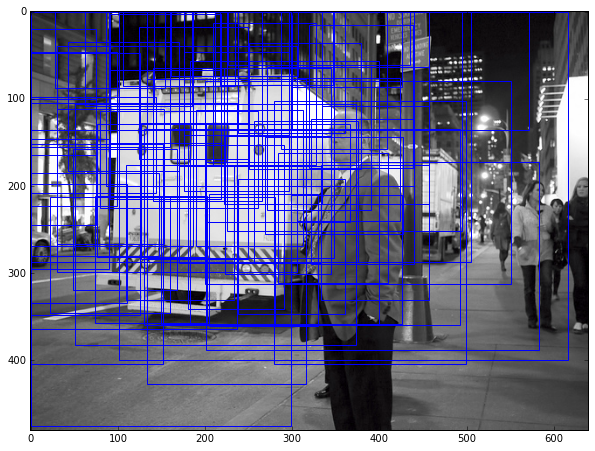

In [17]:
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
im_info = blobs['im_info'][0]
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)
# Create a Rectangle patch
for i, box_data in enumerate(data):
    box = box_data[1:]
    print box
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=1,edgecolor='b',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()